In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import json
import h5py
import os
import sys
try:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
    import cv2
except:
    pass

import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, \
                            BatchNormalization, Activation, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import pickle

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import seaborn as sns


from sklearn.manifold import TSNE

Using TensorFlow backend.


In [3]:
all_images_list = []
for i in os.listdir('stuart_contrib/album_images_(cleaned)'):
    im = cv2.imread('stuart_contrib/album_images_(cleaned)'+'/'+i)
    all_images_list.append(np.array(im)/255.)
all_images_list = np.array(all_images_list)

print('All images now imported.')
print(all_images_list.shape)

All images now imported.
(10156, 128, 128, 3)


# Straight Autoencoder

In [26]:
def get_autoencoder():
    input_img = Input(shape=(128, 128, 3))
    x = Conv2D(64, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name="encoded")(x)
    #encoder = Model(input_img, encoded)
    
    x = Conv2D(16, (3, 3), padding='same')(encoded)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    decoded = Activation('sigmoid')(x)
    #decoder = Model(encoded, decoded)
    model = Model(input_img, decoded)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

In [7]:
batch_size = 64
num_classes = 10
epochs = 400
x_train = all_images_list

autoencoder, encoder, decoder = get_autoencoder()
history = autoencoder.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True)

/home/meschw04/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:180: UserWarning: Model inputs must come from `keras.layers.Input` (thus holding past layer metadata), they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to your model was not an Input tensor, it was generated by layer encoded.
Note that input tensors are instantiated via `tensor = keras.layers.Input(shape)`.
The tensor that caused the issue was: encoded_1/MaxPool:0
  str(x.name))


ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_2:0", shape=(?, 128, 128, 3), dtype=float32) at layer "input_2". The following previous layers were accessed without issue: []

In [6]:
autoencoder.save('records_ae_v1.h5')

In [28]:
parse_autoencoder= load_model('records_ae_v1.h5')
#parse_autoencoder.summary()

parse_encoder = Model(parse_autoencoder.input, parse_autoencoder.layers[12].output)

parse_decoder_input = Input(shape=(16,16,16,))
parse_decoder = Model(parse_decoder_input, parse_autoencoder.layers[27](
                                            parse_autoencoder.layers[26](
                                            parse_autoencoder.layers[25](
                                            parse_autoencoder.layers[24](
                                            parse_autoencoder.layers[23](
                                            parse_autoencoder.layers[22](
                                            parse_autoencoder.layers[21](
                                            parse_autoencoder.layers[20](
                                            parse_autoencoder.layers[19](
                                            parse_autoencoder.layers[18](
                                            parse_autoencoder.layers[17](
                                            parse_autoencoder.layers[16](
                                            parse_autoencoder.layers[15](
                                            parse_autoencoder.layers[14](
                                            parse_autoencoder.layers[13](parse_decoder_input))))))))))))))))

parse_encoder.summary()
parse_decoder.summary()

parse_encoder.save('records_auto-enc_v1.h5')
parse_decoder.save('records_auto-dec_v1.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 32)        128       
__________

In [30]:
load_encoder = load_model('records_auto-enc_v1.h5')
load_decoder = load_model('records_auto-dec_v1.h5')
ae = load_model('records_ae_v1.h5')

/home/meschw04/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


1030 7347


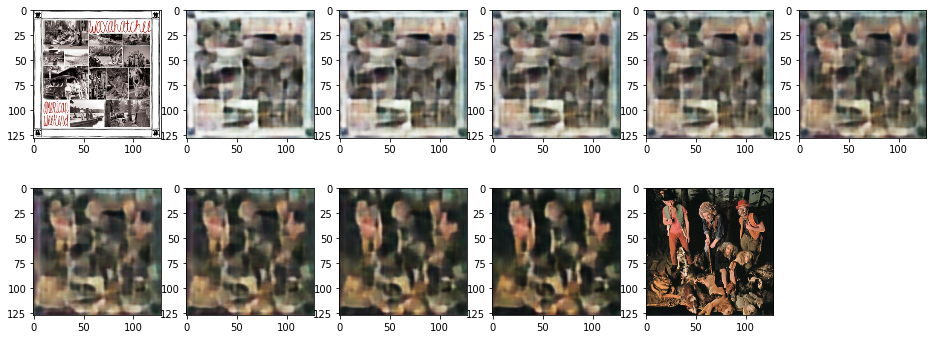

In [109]:
index1 = np.random.randint(len(x_train))
index2 = np.random.randint(len(x_train))
print(index1,index2)

#plt.figure()
#plt.imshow(cv2.cvtColor(np.uint8(x_train[index1]*255), cv2.COLOR_BGR2RGB))
#plt.show()

#plt.figure()
#plt.imshow(cv2.cvtColor(np.uint8(x_train[index2]*255), cv2.COLOR_BGR2RGB))
#plt.show()

f, axarr = plt.subplots(2, 6, figsize=(16,6))
axarr[0,0].imshow(cv2.cvtColor(np.uint8(x_train[index1]*255), cv2.COLOR_BGR2RGB))

interp_space = np.linspace(0.1,0.9,9)

test1 = load_encoder.predict(np.array([x_train[index1]]))
test2 = load_encoder.predict(np.array([x_train[index2]]))

for i in range(len(interp_space)):
    interp_01 = np.array(test1)+interp_space[i]*(np.array(test2)-np.array(test1))

    out_interp_01 = load_decoder.predict(interp_01)
    if i<5:
        axarr[0,i%5+1].imshow(cv2.cvtColor(np.uint8(out_interp_01[0]*255), cv2.COLOR_BGR2RGB))
    else:
        axarr[1,i%5].imshow(cv2.cvtColor(np.uint8(out_interp_01[0]*255), cv2.COLOR_BGR2RGB))

axarr[1,4].imshow(cv2.cvtColor(np.uint8(x_train[index2]*255), cv2.COLOR_BGR2RGB))
axarr[1,5].set_axis_off()
plt.show()

(128, 128, 3)
(10, 128, 128, 3)
   Original ===  AE


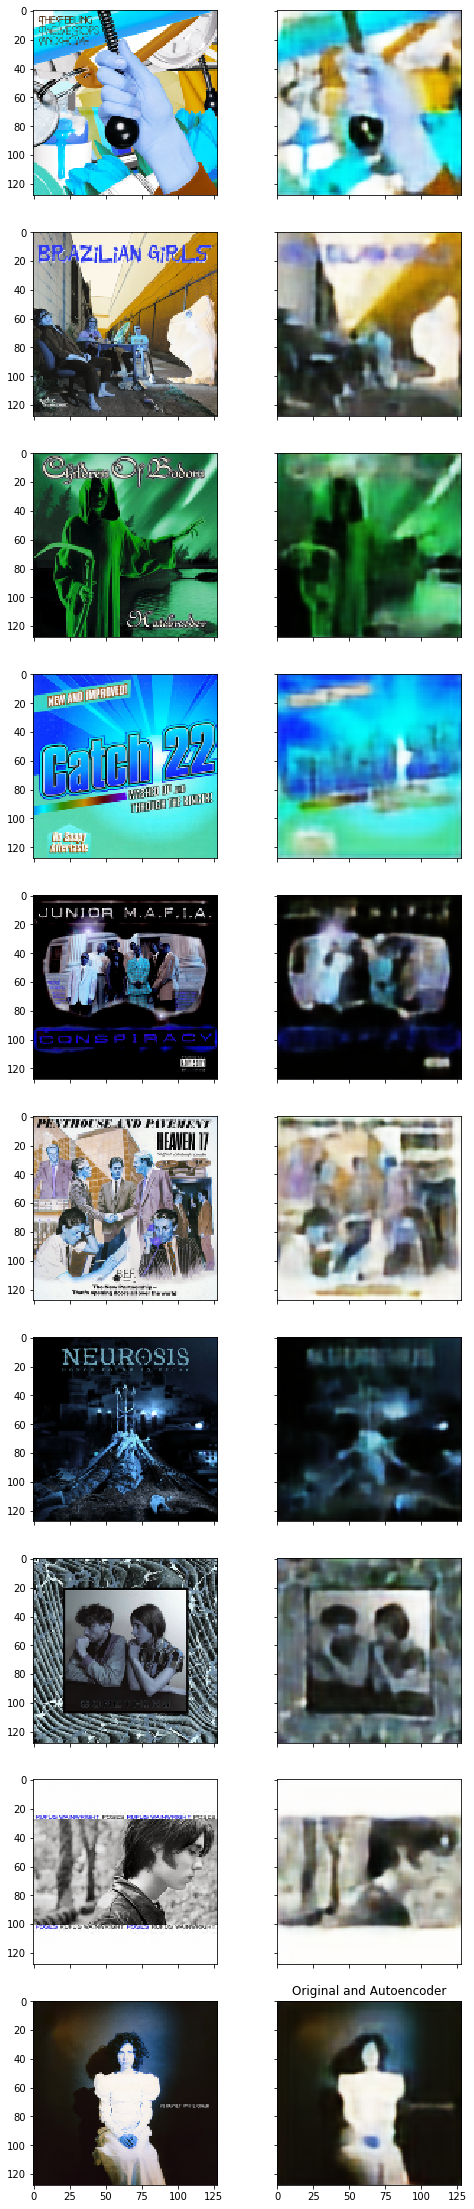

In [33]:
from skimage.io import imshow, imsave
import matplotlib.pyplot as plt
%matplotlib inline

n_samples = 10
start_index = 5000
end_index = start_index + n_samples

pred_set = np.array([x_train[i] for i in range(start_index,start_index+n_samples)])
#pred_set = x_train[start_index:start_index+end_index,:,:,:]
out_ae = ae.predict(pred_set)

print(x_train[0].shape)
print(pred_set.shape)
fig_size = (8,40)

f, axarr = plt.subplots(end_index-start_index, 2, figsize=fig_size)
for i in range(n_samples):
    axarr[i,0].imshow(pred_set[i])
    axarr[i,1].imshow(out_ae[i])
#    axarr[i,2].imshow(out_vae[i])
    for ax in axarr.flat:
        ax.label_outer()
plt.show()